# IMPORT

In [34]:
try:
    import google.colab
    colab = True
except:
    colab = False

if colab:
    !git clone "https://github.com/cybernetic-m/eai-project.git"

In [35]:
# Model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

# Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import gdown

import os
import io
import sys
import traceback
from datetime import datetime
 
import json

# Our file
if colab:
    sys.path.append('/content/eai-project/training')
    sys.path.append('/content/eai-project/preprocessing')
    sys.path.append('/content/eai-project/dataset')
    sys.path.append('/content/eai-project/utils')
    from train import train
    from preprocessing import *
    from thermal_dataset import thermal_dataset
    from utils import *
    prefix = '/content'
        
else:
    from training.train import train
    from preprocessing.preprocessing import *
    from dataset.thermal_dataset import thermal_dataset
    from utils.csv_utils import *
    prefix = '.'
    
pd.set_option('display.max_columns', None)

In [36]:
PE_plot = False
not_skip = True
if os.path.exists(prefix+'/X.npy') and os.path.exists(prefix+'/Y.npy'):
    not_skip = False

**Reproducibility and Device Setting**

In [37]:
# Set a seed for reproducibility purposes
seed = 46
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
#random.seed(seed)

# Set the device (cuda for Nvidia GPUs, mps for M1, M2 .. Apple Silicon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# DATASET

In [38]:
link_zipped_csv = 'https://drive.google.com/file/d/1MssQF4pI_rZqiiDBP4XaLTT1ZaN6ykLm/view?usp=drive_link'
gdrive_link = 'https://drive.google.com/uc?id='
csv_dir = './csv'
zipped_file = './csv.zip'

download_csv(
    link_zipped_csv,
    gdrive_link,
    zipped_file
)

unzip_csv(
    zipped_file,
    csv_dir,
)


CSV file already downloaded!
CSV file already unzipped!


In [39]:
if not_skip:

    path = '/content/csv/thermal_drift_features_lab_05_02.csv'


    features_1 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_02.csv'))
    features_2 = pd.read_csv(os.path.join(prefix, 'csv/thermal_drift_features_lab_05_03.csv'))
    features_3 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_04.csv'))
    features_4 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_05.csv'))
    features_5 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_06.csv'))

    targets_1 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_02.csv'))
    targets_2 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_03.csv'))
    targets_3 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_04.csv'))
    targets_4 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_05.csv'))
    targets_5 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_06.csv'))
    
    features = pd.concat([features_1,features_2,features_3,features_4,features_5])

    features.drop([
        "name", "tags",
        "2\"Tray1 Vacuum Sensor", "2\"Tray2 Vacuum Sensor", "2\"Tray3 Vacuum Sensor",
        "Avg Oven Temperature", "Chuck Temp [Cdeg]", "Chuck Temp2 [Cdeg]",
        "Chuck1 Vacuum Sensor", "Contrast", "Device State",
        "Dispenser1 Pressure Sensor", "Machine Room Temp", "Main Air", "Main Vacuum",
        "Oven Temperature", "PE_Rx", "PE_Ry", "PE_Rz", "PE_X1", "PE_Y1", "PE_Z1",
        "PUT1 Flow Sensor", "PUT2 Flow Sensor1", "PUT2 Flow Sensor2",
        "PUT2 Flow Sensor3", "PUT2 Flow Sensor4", "PUT2 Flow Sensor5",
        "Photodiode", "Pixel Power", "Preciser1 Vacuum Sensor",
        "Tec FIB1 Holder", "Tec FIB1 Plate", "Tec FIB2 Holder", "Tec FIB2 Plate",
        "Torque11","Torque2","Torque3","Torque4","Torque5","Torque6"
    ], axis=1, inplace=True)

    targets_norm_1= normalize_columns(targets_1, ['X1','Y1','Z1'])
    targets_norm_2= normalize_columns(targets_2, ['X1','Y1','Z1'])
    targets_norm_3= normalize_columns(targets_3, ['X1','Y1','Z1'])
    targets_norm_4= normalize_columns(targets_4, ['X1','Y1','Z1'])
    targets_norm_5= normalize_columns(targets_5, ['X1','Y1','Z1'])

    targets = pd.concat([targets_1,targets_2,targets_3,targets_4,targets_5])
    
    targets.drop(['name', 'tags'], axis=1, inplace=True)


In [40]:
if not_skip:
    features

In [41]:
if not_skip:

    targets.head(10)

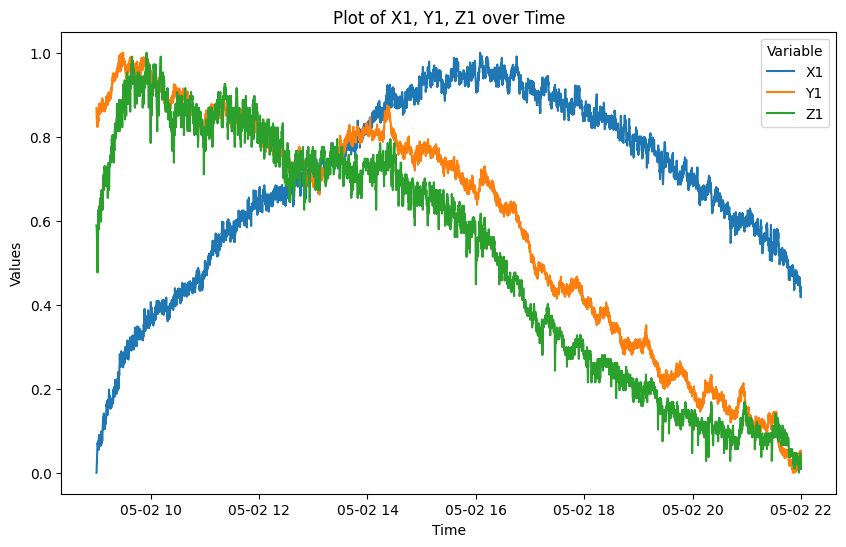

In [42]:
if not_skip:

    targets_norm_1['time'] = pd.to_datetime(targets_norm_1['time'], unit='ns')

    # Reshape the DataFrame using melt()
    targets_melted = targets_norm_1.reset_index().melt(id_vars=['time'], value_vars=['X1', 'Y1', 'Z1'], var_name='variable', value_name='value')

    # Drop rows where 'value' is NaN (to keep only the non-null entries)
    targets_melted = targets_melted.dropna(subset=['value'])

    # Plot the data
    plt.figure(figsize=(10, 6))
    for var in targets_melted['variable'].unique():
        # Filter data for each variable and plot
        temp_df = targets_melted[targets_melted['variable'] == var]
        plt.plot(temp_df['time'], temp_df['value'], label=var)

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Plot of X1, Y1, Z1 over Time')
    plt.legend(title='Variable')

    # Show the plot
    plt.show()

    #targets.plot(y='X1',x='time')

In [43]:
if not_skip:

    # Convert 'time' to datetime (nanoseconds to datetime)
    features['time'] = pd.to_datetime(features_1['time'], unit='ns')

    # Set 'time' as the index
    features.set_index('time', inplace=True)

    # Optionally, you can plot X1, Y1, Z1 directly
    features[['Temp Sensor 1', 'Temp Sensor 2', 'Temp Sensor 3', 'Temp Sensor 4', ]].plot()

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Plot of Temp Sensor 1, Temp Sensor 2, Temp Sensor 3, Temp Sensor 4 over Time')

    # Show the plot
    plt.show()

In [ ]:

if PE_plot and not_skip:
  # Optionally, you can plot X1, Y1, Z1 directly
  features[['PE_X1', 'PE_Y1']].plot()

  # Add labels and title
  plt.xlabel('Time')
  plt.ylabel('Values')
  plt.title('Plot of Temp Sensor 1, Temp Sensor 2, Temp Sensor 3, Temp Sensor 4 over Time')

  # Show the plot
  plt.show()

In [ ]:
if not_skip:

    fixed_targets = transform_dataframe(targets)

In [ ]:
if not_skip:

    fixed_targets

In [ ]:
if not_skip:

    complete_numbers = merge_on_closest_time(fixed_targets.reset_index(), features.reset_index())

In [ ]:
if not_skip:

    complete = complete_numbers.rename(columns={
        0: 'id',
        1: 'time',
        2: 'X1',
        3: 'Y1',
        4: 'Z1',
        5: 'to_remove',
        6: 'Temp1',
        7: 'Temp2',
        8: 'Temp3',
        9: 'Temp4'
        })
    complete.drop(['to_remove', 'time'], axis=1, inplace=True)

In [ ]:
if not_skip:

    complete

In [ ]:
if not_skip:

    complete.astype(float)

    X = complete[['Temp1','Temp2', 'Temp3', 'Temp4']]
    Y = complete[['X1', 'Y1', 'Z1']]

    Y = Y.values.astype(np.float32)
    Y = np.gradient(Y, axis=0)
    X = X.values.astype(np.float32)
    X /= 100

    np.save(prefix+'/X.npy',X)
    np.save(prefix+'/Y.npy',Y)

In [ ]:
if not not_skip:
    X = np.load(prefix+'/X.npy')
    Y = np.load(prefix+'/Y.npy')

print(X)
print(Y)


[[21.36 21.64 21.63 21.59]
 [21.36 21.7  21.62 21.6 ]
 [21.36 21.76 21.63 21.6 ]
 ...
 [21.04 21.37 21.45 21.57]
 [21.04 21.37 21.45 21.57]
 [21.04 21.37 21.45 21.57]]
[[ 0.0234375  -0.09765625  0.        ]
 [ 0.03125    -0.04882812 -0.0390625 ]
 [ 0.02929688 -0.02148438 -0.078125  ]
 ...
 [ 0.015625   -0.03125     0.05859375]
 [ 0.01171875 -0.02734375  0.05859375]
 [-0.015625   -0.03515625  0.        ]]


In [ ]:
def split(listToSplit, splitPercentages):
  length = len(listToSplit)
  splittedList = []
  lastIndex = 0
  for percentageIndex in range(len(splitPercentages)):
    print(lastIndex)
    splittedList.append(listToSplit[lastIndex:lastIndex+int(splitPercentages[percentageIndex]*length)])
    lastIndex += int(splitPercentages[percentageIndex]*length)

  return splittedList

In [ ]:
splitPerc = [0.7,0.2,0.1]
splitted_X = split(X, splitPerc)
splitted_Y = split(Y, splitPerc)

0
21273
27351
0
21273
27351


In [ ]:
datasetTrain = thermal_dataset((splitted_X[0],splitted_Y[0]), 5, device)
datasetTest = thermal_dataset((splitted_X[1],splitted_Y[1]), 5, device)
datasetVal = thermal_dataset((splitted_X[2],splitted_Y[2]), 5, device)

# MODEL

In [ ]:
class lstm_extractor(nn.Module):
  def __init__(self, feature_dim, input_dim):
    super(lstm_extractor, self).__init__()
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=feature_dim, batch_first=True)

  def forward(self, x):
    output, (hidden_state, cell_state) = self.lstm(x)
    return output


In [ ]:
class rnn_extractor(nn.Module):
  def __init__(self, feature_dim, input_dim):
    super(rnn_extractor, self).__init__()
    self.rnn = nn.RNN(input_size=input_dim, hidden_size=feature_dim, batch_first=True)

  def forward(self, x):
    output, (hidden_state, cell_state) = self.rnn(x)
    #print(hidden_state.shape)

    return output

In [ ]:
class complete_model(nn.Module):
  def __init__(self, hidden_dim, input_dim, output_dim):
    super(complete_model, self).__init__()
    self.extractor = lstm_extractor(hidden_dim, input_dim)
    self.out = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    #print(x.shape)
    x = self.extractor(x)[:, -1, :]
    x = self.out(x)
    return x
  
  def save(self, epoch):

    # Get current timestamp
    current_time = datetime.now().strftime('%Y-%m-%d_%H')

    # Create the directory of results
    dir_path = 'results/training_' + current_time # path of type 'results/training_2024-12-22_14
    os.makedirs(dir_path, exist_ok=True) # Create the directory

    save_name = 'model_' + str(epoch) + '.pt' # Model name of the type 'model_50.pt' where 50 is the epoch 
    save_path = os.path.join(dir_path, save_name) # path of type '/training_2024-12-22_14-57/model_50.pt
    torch.save(self.state_dict(), save_path) # Save the model
    print(f'Model saved to {save_path}')
    return dir_path

In [ ]:
hyper_parameters = {'batch_size': 8,
                    'hidden_dim' : 10,
                    'input_dim':4,
                    'output_dim':3,
                    'lr':0.001
                    }

In [ ]:
loaderTrain = DataLoader(datasetTrain, shuffle=True, batch_size=hyper_parameters['batch_size'], drop_last=True, collate_fn=pad_collate_fn)
loaderTest = DataLoader(datasetTest, shuffle=True, batch_size=hyper_parameters['batch_size'], drop_last=True, collate_fn=pad_collate_fn)
loaderVal = DataLoader(datasetVal, shuffle=True, batch_size=hyper_parameters['batch_size'], drop_last=True, collate_fn=pad_collate_fn)
model = complete_model(hidden_dim=hyper_parameters['hidden_dim'], input_dim=hyper_parameters['input_dim'], output_dim=hyper_parameters['output_dim']).to(device)
optimizer = optim.Adam(model.parameters(), lr=hyper_parameters['lr'])
loss_fn = nn.MSELoss()

In [ ]:
train(
    num_epochs=5,
    loss_fn=loss_fn,
    model=model,
    optimizer=optimizer,
    training_dataloader=loaderTrain,
    validation_dataloader=loaderVal,
    hyperparams=hyper_parameters,
)

EPOCH 1/5:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x770d8fe0a270>>
Traceback (most recent call last):
  File "/home/paolo/uni/magistrale/Napoli/eai-project/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
